In [1]:
# Import all the Dependencies

from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML


In [2]:
# Set all the Constants

BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
# Import data into tensorflow dataset object

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../Tea_Leaf_Disease",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5867 files belonging to 6 classes.


2022-07-18 11:10:55.423069: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-18 11:10:55.423146: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (user-MS-7994): /proc/driver/nvidia/version does not exist
2022-07-18 11:10:55.423446: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
class_names = dataset.class_names
class_names

['algal_spot',
 'brown_blight',
 'gray_blight',
 'healthy',
 'helopeltis',
 'red_spot']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[4 2 3 2 2 4 2 1 3 3 2 5 4 0 4 1 4 5 4 2 0 4 1 0 1 4 2 4 3 4 5 5]


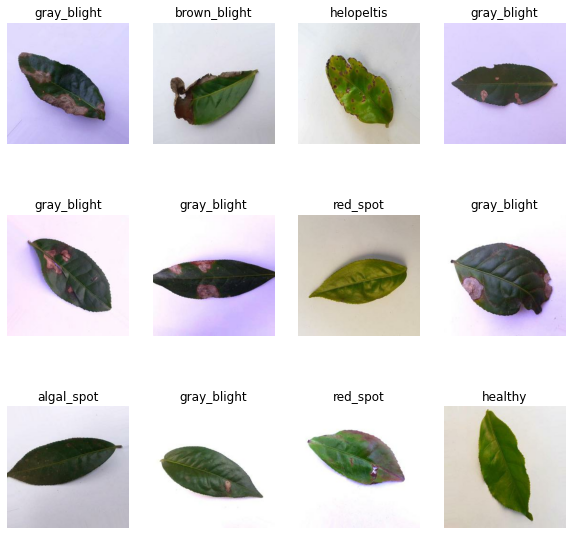

In [6]:
# Visualize some of the images from our dataset

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [14]:
# Function to Split Dataset

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

147

In [17]:
len(val_ds)

18

In [18]:
len(test_ds)

19

In [19]:
# Cache, Shuffle, and Prefetch the Dataset

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
# Creating a Layer for Resizing and Normalization

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
# Data Augmentation

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
# Applying Data Augmentation to Train Dataset

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
# Building the Model 

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [25]:
# Compiling the Model

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
# Train the model

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
147/147 [==============================] - ETA: 0s - loss: 1.4324 - accuracy: 0.3666

2022-07-18 11:14:37.595698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 161 of 10000
2022-07-18 11:14:42.595308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.
2022-07-18 11:14:42.595601: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1 of 1000
2022-07-18 11:14:42.595748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


147/147 [==============================] - 230s 2s/step - loss: 1.4324 - accuracy: 0.3666 - val_loss: 1.2277 - val_accuracy: 0.4306
Epoch 2/50
147/147 [==============================] - 188s 1s/step - loss: 1.2246 - accuracy: 0.4743 - val_loss: 1.1549 - val_accuracy: 0.5069
Epoch 3/50
147/147 [==============================] - 201s 1s/step - loss: 1.1187 - accuracy: 0.5234 - val_loss: 1.1177 - val_accuracy: 0.5538
Epoch 4/50
147/147 [==============================] - 221s 2s/step - loss: 1.0389 - accuracy: 0.5627 - val_loss: 0.9935 - val_accuracy: 0.6233
Epoch 5/50
147/147 [==============================] - 218s 1s/step - loss: 0.8592 - accuracy: 0.6474 - val_loss: 0.8360 - val_accuracy: 0.6840
Epoch 6/50
147/147 [==============================] - 202s 1s/step - loss: 0.7606 - accuracy: 0.6953 - val_loss: 0.8085 - val_accuracy: 0.6962
Epoch 7/50
147/147 [==============================] - 201s 1s/step - loss: 0.6943 - accuracy: 0.7160 - val_loss: 0.5659 - val_accuracy: 0.7847
Epoch 8/50

In [27]:
scores = model.evaluate(test_ds)

2022-07-18 13:53:06.814296: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 88 of 10000
2022-07-18 13:53:16.805322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 146 of 10000
2022-07-18 13:53:23.634081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.
2022-07-18 13:53:23.675395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1 of 1000
2022-07-18 13:53:23.675439: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 2 of 1000
2022-07-18 13:53:23.675549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


19/19 [==============================] - 33s 289ms/step - loss: 0.0641 - accuracy: 0.9819


In [28]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 147}

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
type(history.history['loss'])

list

In [31]:
len(history.history['loss'])

50

In [32]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.4323816299438477,
 1.2245981693267822,
 1.1187026500701904,
 1.0389007329940796,
 0.8591541051864624]

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

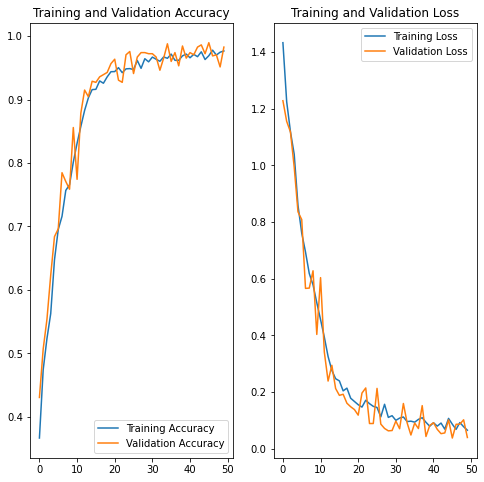

In [34]:
# Plotting the Accuracy and Loss Curves

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: gray_blight
predicted label: gray_blight


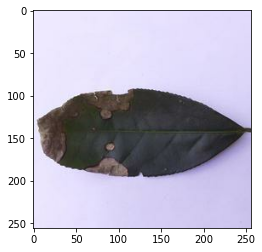

In [35]:
# Run prediction on a sample image

import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [36]:
# Write a function for inference

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

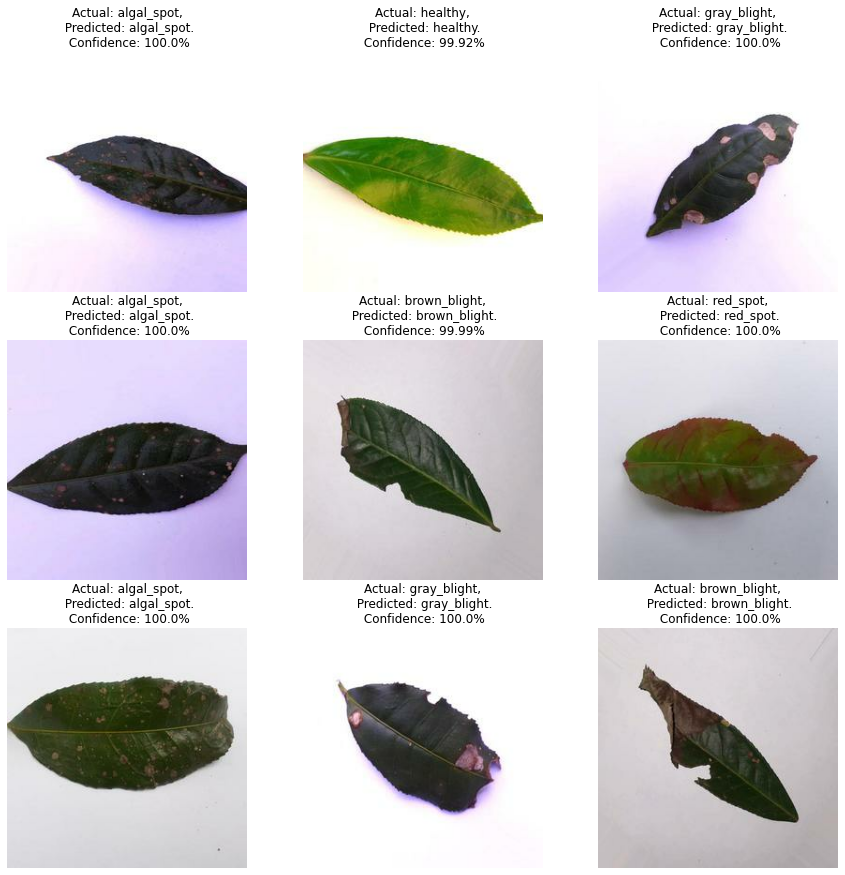

In [37]:
# Now run inference on few sample images

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
# Saving the Model

import os
version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{version}")
model.save("../potatoes.h5")